# GridSearch para regresión (ventas)

**Candidatos**
- BaggingRegressor
- GradientBoostingRegressor
- RandomForestRegressor
- RegresorKNeighbors

In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, OneHotEncoder
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
import pandas as pd
import re
import numpy as np
np.seterr(divide='ignore', invalid='ignore');  # warnings inutiles apagados!

In [2]:
def custom_features(dataframe_in):
    df = dataframe_in.copy(deep=True)

    df['month'] = pd.to_datetime(df['release_date']).dt.month
    df['release_date'] = pd.to_datetime(df['release_date']).apply(lambda x: x.to_julian_date())

    df['revenue'] = pd.Series([0 for _ in range(len(dataframe_in))])

    df.loc[df.publisher.str.match('.*microsoft.*', flags=re.IGNORECASE).values, 'revenue'] = 10.260
    df.loc[df.publisher.str.match('.*netease.*', flags=re.IGNORECASE).values, 'revenue'] = 6.668
    df.loc[df.publisher.str.match('.*activision.*', flags=re.IGNORECASE).values, 'revenue'] = 6.388
    df.loc[df.publisher.str.match('.*electronic.*', flags=re.IGNORECASE).values, 'revenue'] = 5.537
    df.loc[df.publisher.str.match('.*bandai.*', flags=re.IGNORECASE).values, 'revenue'] = 3.018
    df.loc[df.publisher.str.match('.*square.*', flags=re.IGNORECASE).values, 'revenue'] = 2.386
    df.loc[df.publisher.str.match('.*nexon.*', flags=re.IGNORECASE).values, 'revenue'] = 2.286
    df.loc[df.publisher.str.match('.*ubisoft.*', flags=re.IGNORECASE).values, 'revenue'] = 1.446
    df.loc[df.publisher.str.match('.*konami.*', flags=re.IGNORECASE).values, 'revenue'] = 1.303
    df.loc[df.publisher.str.match('.*SEGA.*').values, 'revenue'] = 1.153
    df.loc[df.publisher.str.match('.*capcom.*', flags=re.IGNORECASE).values, 'revenue'] = 0.7673
    df.loc[df.publisher.str.match('.*warner.*', flags=re.IGNORECASE).values, 'revenue'] = 0.7324

    return df

In [3]:
from preprocessing import Nothing, CategoriesTokenizer


boc_some_values = CountVectorizer(
    tokenizer = CategoriesTokenizer(),
    max_df = 1.0,
    min_df = 0.05  # hiperparametro a optimizar
    # valores para GridSearch : [5%, 10%, 15%] ???
    )


boc_many_values = CountVectorizer(
    tokenizer = CategoriesTokenizer(),
    max_df = 1.0,
    min_df = 1  # hiperparametro a optimizar
    # valores para GridSearch : [5, 10, 15] ???
    )


preprocessing = ColumnTransformer(
    transformers=[
        ('BoC-plat',boc_some_values,'platforms'),
        ('BoC-cat',boc_some_values,'categories'),
        ('BoC-genres',boc_some_values,'genres'),
        ('BoC-tags',boc_some_values,'tags'),

        ('BoC-dev',boc_many_values,'developer'),
        ('BoC-pub',boc_many_values,'publisher'),

        ('OneHotEncoder',OneHotEncoder(handle_unknown='ignore'),['month']),
        ('MinMaxScaler',MinMaxScaler(),['required_age','price','release_date']),
        ('BoxCox',PowerTransformer(method='yeo-johnson'),['achievements','average_playtime','revenue']),
        ('unchanged',Nothing(),['english'])
])

In [4]:
df_train = pd.read_pickle('train.pickle')
df_train = custom_features(df_train)

X_train, X_eval, y_train, y_eval = train_test_split(df_train, df_train['estimated_sells'], test_size=0.3, random_state=0)

## Regresor Bagging

In [5]:
from sklearn.ensemble import BaggingRegressor

In [6]:
pipeline = Pipeline(steps = [
    ('procesamiento',preprocessing),
    ("selector", SelectPercentile(f_classif, percentile=95)),
    ("regressor",BaggingRegressor(random_state=0)),
])

In [7]:
grilla_bagging = {
    "regressor": [BaggingRegressor(random_state=0)],
    "selector__percentile" : [75, 85, 95, 100],
    "selector__score_func" : [f_classif],
    "regressor__n_estimators" : [5, 10, 15, 20],
    'regressor__max_samples' : [0.5, 0.75, 1.0]
}

In [8]:
gs_BR = HalvingGridSearchCV(
    pipeline,
    grilla_bagging,
    scoring = 'r2',
    n_jobs=-1,
    verbose = 0,
    random_state = 0
)

In [9]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore');

gs_BR.fit(X_train, y_train)

/home/camilo/miniconda3/envs/prog_cientifica/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:107: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)
/home/camilo/miniconda3/envs/prog_cientifica/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

HalvingGridSearchCV(estimator=Pipeline(steps=[('procesamiento',
                                               ColumnTransformer(transformers=[('BoC-plat',
                                                                                CountVectorizer(min_df=0.05,
                                                                                                tokenizer=<preprocessing.CategoriesTokenizer object at 0x7fd781d29bd0>),
                                                                                'platforms'),
                                                                               ('BoC-cat',
                                                                                CountVectorizer(min_df=0.05,
                                                                                                tokenizer=<preprocessing.CategoriesTokenizer object at 0x7fd781d29bd0>),
                                                                                'categories'),
                                                                               ('BoC-genre...
                                              ('regressor',
                                               BaggingRegressor(random_state=0))]),
                    n_jobs=-1,
                    param_grid={'regressor': [BaggingRegressor(max_samples=0.5,
                                                               n_estimators=15,
                                                               random_state=0)],
                                'regressor__max_samples': [0.5, 0.75, 1.0],
                                'regressor__n_estimators': [5, 10, 15, 20],
                                'selector__percentile': [75, 85, 95, 100],
                                'selector__score_func': [<function f_classif at 0x7fd7908ff2e0>]},
                    random_state=0, scoring='r2')

El mejor modelo encontrado es el siguiente

In [10]:
gs_BR.best_params_ 

{'regressor': BaggingRegressor(max_samples=0.5, n_estimators=15, random_state=0),
 'regressor__max_samples': 0.5,
 'regressor__n_estimators': 15,
 'selector__percentile': 85,
 'selector__score_func': <function sklearn.feature_selection._univariate_selection.f_classif(X, y)>}

Y sus métricas son:

In [11]:
gs_BR.best_score_

0.08266996926313981

In [12]:
print("Resultados clasificador ganador de GridSearch Bagging Regressor")

y_pred = gs_BR.predict(X_eval)
print("Error cuadrático medio = {}".format(mean_squared_error(y_eval,y_pred)))
print("Score R2 = {}".format(r2_score(y_eval,y_pred)))

Resultados clasificador ganador de GridSearch Bagging Regressor
Error cuadrático medio = 1336152518020.4304
Score R2 = 0.25469326611147736


In [13]:
pd.DataFrame(gs_BR.cv_results_)

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor,param_regressor__max_samples,param_regressor__n_estimators,param_selector__percentile,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0,204,0.169083,0.006316,0.003644,0.007288,"BaggingRegressor(max_samples=0.5, n_estimators...",0.5,5,75,...,NaN,NaN,72,NaN,0.462299,NaN,NaN,NaN,NaN,NaN
1,0,204,0.172799,0.007699,0.007955,0.009748,"BaggingRegressor(max_samples=0.5, n_estimators...",0.5,5,85,...,NaN,NaN,39,0.713506,0.457114,NaN,NaN,NaN,NaN,NaN
2,0,204,0.186861,0.010108,0.017904,0.009034,"BaggingRegressor(max_samples=0.5, n_estimators...",0.5,5,95,...,NaN,NaN,35,0.728070,0.463003,0.331125,0.463907,NaN,NaN,NaN
3,0,204,0.171700,0.029609,0.017485,0.002202,"BaggingRegressor(max_samples=0.5, n_estimators...",0.5,5,100,...,0.182814,0.284509,9,0.742387,0.541309,0.269652,0.446045,0.556231,0.511125,0.154254
4,0,204,0.156279,0.016056,0.004343,0.008687,"BaggingRegressor(max_samples=0.5, n_estimators...",0.5,10,75,...,NaN,NaN,34,NaN,0.650004,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,2,1836,2.628172,0.074025,0.034227,0.002433,"BaggingRegressor(max_samples=0.5, n_estimators...",0.75,15,85,...,-3.777007,7.871655,22,0.845954,0.810570,0.775273,0.784723,0.648498,0.773004,0.066899
68,2,1836,1.978410,0.268615,0.030130,0.006718,"BaggingRegressor(max_samples=0.5, n_estimators...",0.5,15,85,...,-3.057964,6.368244,21,0.733837,0.730940,0.585492,0.575966,0.517386,0.628724,0.087802
69,2,1836,0.958396,0.047670,0.015913,0.000554,"BaggingRegressor(max_samples=0.5, n_estimators...",0.5,5,75,...,-2.975106,6.277445,20,0.660126,0.624468,0.448303,0.439312,0.362828,0.507007,0.114942
70,3,5508,7.330613,0.181436,0.033912,0.002255,"BaggingRegressor(max_samples=0.5, n_estimators...",0.5,15,85,...,0.082670,0.083986,16,0.718068,0.553053,0.569901,0.661763,0.506469,0.601851,0.076936


In [14]:
pd.DataFrame(gs_BR.cv_results_)['mean_test_score'].max()

0.29635884201015195

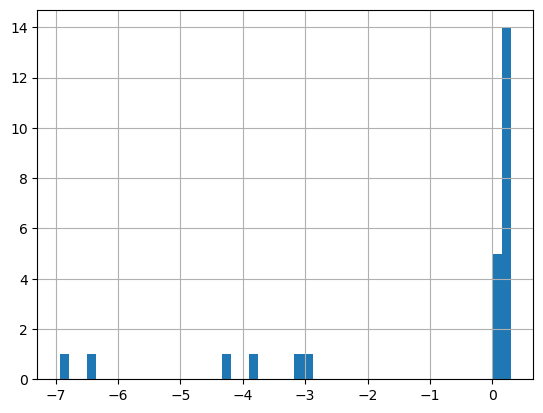

In [78]:
pd.DataFrame(gs_BR.cv_results_)['mean_test_score'].hist(bins=50);

## Regresor GradientBoosting

In [19]:
from sklearn.ensemble import GradientBoostingRegressor

grilla_GB = {
    "regressor": [GradientBoostingRegressor(random_state=0)],
    "regressor__n_estimators" :[25, 50, 100, 250, 500],
    "regressor__learning_rate" : [0.05, 0.1, 0.2],
    "selector__percentile" : [75, 85, 95, 100],
    "selector__score_func" : [f_classif],
    "procesamiento__BoC-cat__min_df" : [0.05, 0.1],
    "procesamiento__BoC-genres__min_df" : [0.05, 0.1],
    "procesamiento__BoC-tags__min_df" : [0.05, 0.1],
    "procesamiento__BoC-dev__min_df" : [2, 5],
    "procesamiento__BoC-pub__min_df" : [2, 5],
}

gs_GB = HalvingGridSearchCV(
    pipeline,
    grilla_GB,
    scoring = 'r2',
    n_jobs=-1,
    verbose = 0,
    random_state = 1
)

In [20]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore');

gs_GB.fit(X_train, y_train)

/home/camilo/miniconda3/envs/prog_cientifica/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:107: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)
/home/camilo/miniconda3/envs/prog_cientifica/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/camilo/miniconda3/envs/prog_cientifica/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:107: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)
/home/camilo/miniconda3/envs/prog_cientifica/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/camilo/miniconda3/envs/prog_cientifica/lib/python3.10/site-packages/sklearn/feature_selection/_univari

HalvingGridSearchCV(estimator=Pipeline(steps=[('procesamiento',
                                               ColumnTransformer(transformers=[('BoC-plat',
                                                                                CountVectorizer(min_df=0.05,
                                                                                                tokenizer=<preprocessing.CategoriesTokenizer object at 0x7fd781d29bd0>),
                                                                                'platforms'),
                                                                               ('BoC-cat',
                                                                                CountVectorizer(min_df=0.05,
                                                                                                tokenizer=<preprocessing.CategoriesTokenizer object at 0x7fd781d29bd0>),
                                                                                'categories'),
                                                                               ('BoC-genre...
                                'procesamiento__BoC-tags__min_df': [0.05, 0.1],
                                'regressor': [GradientBoostingRegressor(learning_rate=0.05,
                                                                        n_estimators=25,
                                                                        random_state=0)],
                                'regressor__learning_rate': [0.05, 0.1, 0.2],
                                'regressor__n_estimators': [25, 50, 100, 250,
                                                            500],
                                'selector__percentile': [75, 85, 95, 100],
                                'selector__score_func': [<function f_classif at 0x7fd7908ff2e0>]},
                    random_state=1, scoring='r2')

El mejor modelo encontrado es el siguiente

In [21]:
gs_GB.best_params_ 

{'procesamiento__BoC-cat__min_df': 0.05,
 'procesamiento__BoC-dev__min_df': 5,
 'procesamiento__BoC-genres__min_df': 0.05,
 'procesamiento__BoC-pub__min_df': 2,
 'procesamiento__BoC-tags__min_df': 0.05,
 'regressor': GradientBoostingRegressor(learning_rate=0.05, n_estimators=25, random_state=0),
 'regressor__learning_rate': 0.05,
 'regressor__n_estimators': 25,
 'selector__percentile': 75,
 'selector__score_func': <function sklearn.feature_selection._univariate_selection.f_classif(X, y)>}

Y sus métricas son

In [22]:
gs_GB.best_score_

-0.3357816957920462

In [23]:
print("Resultados clasificador ganador de GridSearch GradienBoosting Regressor")

y_pred = gs_GB.predict(X_eval)
print("Error cuadrático medio = {}".format(mean_squared_error(y_eval,y_pred)))
print("Score R2 = {}".format(r2_score(y_eval,y_pred)))

Resultados clasificador ganador de GridSearch GradienBoosting Regressor
Error cuadrático medio = 1070754782083.177
Score R2 = 0.4027322939058916


Resultados generales del gridsearch

In [24]:
pd.DataFrame(gs_GB.cv_results_)

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_procesamiento__BoC-cat__min_df,param_procesamiento__BoC-dev__min_df,param_procesamiento__BoC-genres__min_df,param_procesamiento__BoC-pub__min_df,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0,10,0.007617,0.006995,0.002285,0.004570,0.05,2,0.05,2,...,NaN,NaN,1440,NaN,NaN,NaN,NaN,0.912804,NaN,NaN
1,0,10,0.007698,0.007340,0.001421,0.002841,0.05,2,0.05,2,...,NaN,NaN,1913,NaN,NaN,NaN,NaN,0.912804,NaN,NaN
2,0,10,0.009600,0.011134,0.001887,0.003774,0.05,2,0.05,2,...,NaN,NaN,1914,NaN,NaN,NaN,NaN,0.916708,NaN,NaN
3,0,10,0.009586,0.006181,0.003411,0.006823,0.05,2,0.05,2,...,NaN,NaN,1915,NaN,NaN,NaN,NaN,0.916708,NaN,NaN
4,0,10,0.010413,0.012436,0.005434,0.010868,0.05,2,0.05,2,...,NaN,NaN,1916,NaN,NaN,NaN,NaN,0.992511,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2873,5,2430,2.056054,0.097832,0.036042,0.001887,0.05,5,0.1,2,...,-0.604874,0.918659,3,0.994562,0.989847,0.991917,0.969565,0.970414,0.983261,0.010942
2874,5,2430,1.727037,0.066803,0.031990,0.002271,0.05,5,0.05,2,...,-0.335782,0.437835,1,0.874580,0.839330,0.855689,0.691241,0.709284,0.794025,0.077575
2875,5,2430,3.613343,0.086987,0.037960,0.004767,0.1,5,0.1,5,...,-0.855403,0.950983,8,0.999544,0.999311,0.999430,0.997419,0.997496,0.998640,0.000969
2876,5,2430,2.003715,0.091565,0.034844,0.002919,0.05,5,0.1,2,...,-0.792038,0.932493,7,0.989480,0.975266,0.984452,0.939178,0.936307,0.964937,0.022685


In [25]:
pd.DataFrame(gs_GB.cv_results_)['mean_test_score'].max()

-0.3357816957920462

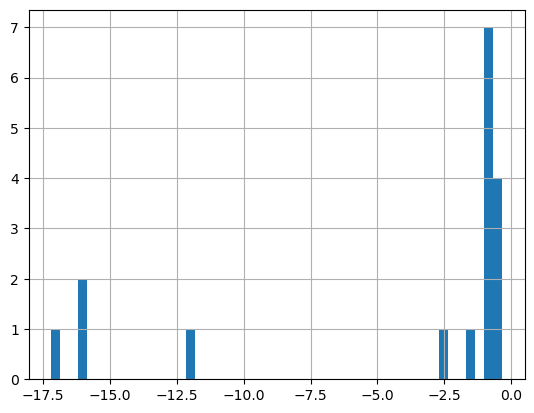

In [79]:
pd.DataFrame(gs_GB.cv_results_)['mean_test_score'].hist(bins=50);

## Regresor RandomForest

In [26]:
from sklearn.ensemble import RandomForestRegressor

In [27]:
grilla_RF = {
    "regressor": [RandomForestRegressor(random_state=0)],
    "regressor__n_estimators" :[25, 50, 100, 250, 500],
    "selector__percentile" : [75, 85, 95, 100],
    "selector__score_func" : [f_classif],
    "procesamiento__BoC-cat__min_df" : [0.05, 0.1],
    "procesamiento__BoC-genres__min_df" : [0.05, 0.1],
    "procesamiento__BoC-tags__min_df" : [0.05, 0.1],
    "procesamiento__BoC-dev__min_df" : [2, 5],
    "procesamiento__BoC-pub__min_df" : [2, 5],
}

gs_RF = HalvingGridSearchCV(
    pipeline,
    grilla_RF,
    scoring = 'r2',
    n_jobs=-1,
    verbose = 0,
    random_state = 1
)

In [28]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore');

gs_RF.fit(X_train, y_train)

/home/camilo/miniconda3/envs/prog_cientifica/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:107: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)
/home/camilo/miniconda3/envs/prog_cientifica/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:107: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)
/home/camilo/miniconda3/envs/prog_cientifica/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:107: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)
/home/camilo/miniconda3/envs/prog_cientifica/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:107: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)
/home/camilo/miniconda3/envs/prog_cientifica/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:107: RuntimeWarning: invalid value enco

HalvingGridSearchCV(estimator=Pipeline(steps=[('procesamiento',
                                               ColumnTransformer(transformers=[('BoC-plat',
                                                                                CountVectorizer(min_df=0.05,
                                                                                                tokenizer=<preprocessing.CategoriesTokenizer object at 0x7fd781d29bd0>),
                                                                                'platforms'),
                                                                               ('BoC-cat',
                                                                                CountVectorizer(min_df=0.05,
                                                                                                tokenizer=<preprocessing.CategoriesTokenizer object at 0x7fd781d29bd0>),
                                                                                'categories'),
                                                                               ('BoC-genre...
                                'procesamiento__BoC-genres__min_df': [0.05,
                                                                      0.1],
                                'procesamiento__BoC-pub__min_df': [2, 5],
                                'procesamiento__BoC-tags__min_df': [0.05, 0.1],
                                'regressor': [RandomForestRegressor(n_estimators=500,
                                                                    random_state=0)],
                                'regressor__n_estimators': [25, 50, 100, 250,
                                                            500],
                                'selector__percentile': [75, 85, 95, 100],
                                'selector__score_func': [<function f_classif at 0x7fd7908ff2e0>]},
                    random_state=1, scoring='r2')

El mejor modelo encontrado es este

In [38]:
gs_RF.best_params_ 

{'procesamiento__BoC-cat__min_df': 0.05,
 'procesamiento__BoC-dev__min_df': 5,
 'procesamiento__BoC-genres__min_df': 0.1,
 'procesamiento__BoC-pub__min_df': 2,
 'procesamiento__BoC-tags__min_df': 0.1,
 'regressor': RandomForestRegressor(n_estimators=500, random_state=0),
 'regressor__n_estimators': 500,
 'selector__percentile': 100,
 'selector__score_func': <function sklearn.feature_selection._univariate_selection.f_classif(X, y)>}

Y sus métricas son

In [39]:
gs_RF.best_score_

-0.2740251965505843

In [40]:
print("Resultados clasificador ganador de GridSearch RandomForest Regressor")

y_pred = gs_RF.predict(X_eval)
print("Error cuadrático medio = {}".format(mean_squared_error(y_eval,y_pred)))
print("Score R2 = {}".format(r2_score(y_eval,y_pred)))

Resultados clasificador ganador de GridSearch RandomForest Regressor
Error cuadrático medio = 802918483041.1865
Score R2 = 0.5521315537684721


Resultados generales del gridsearch

In [41]:
pd.DataFrame(gs_RF.cv_results_)

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_procesamiento__BoC-cat__min_df,param_procesamiento__BoC-dev__min_df,param_procesamiento__BoC-genres__min_df,param_procesamiento__BoC-pub__min_df,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0,22,0.029845,0.029202,0.002667,0.005335,0.05,2,0.05,2,...,NaN,NaN,481,NaN,NaN,NaN,NaN,0.876056,NaN,NaN
1,0,22,0.025443,0.027083,0.003660,0.007319,0.05,2,0.05,2,...,NaN,NaN,633,NaN,NaN,NaN,NaN,0.852413,NaN,NaN
2,0,22,0.027694,0.038540,0.003650,0.007299,0.05,2,0.05,2,...,NaN,NaN,634,NaN,NaN,NaN,NaN,0.819059,NaN,NaN
3,0,22,0.023856,0.030709,0.003372,0.006744,0.05,2,0.05,2,...,NaN,NaN,635,NaN,NaN,NaN,NaN,0.861613,NaN,NaN
4,0,22,0.020354,0.026180,0.002380,0.004759,0.05,2,0.05,2,...,NaN,NaN,636,NaN,NaN,NaN,NaN,0.874535,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
956,4,1782,33.832851,1.538523,0.112947,0.024057,0.05,5,0.1,2,...,-0.762065,1.877027,5,0.868591,0.861151,0.858499,0.906305,0.904283,0.879766,0.021114
957,4,1782,24.707388,2.144771,0.083997,0.012859,0.1,5,0.1,5,...,-0.909376,2.164422,8,0.873471,0.857477,0.859937,0.906004,0.899235,0.879225,0.019978
958,5,5346,187.022794,1.344040,0.241670,0.025871,0.05,5,0.1,2,...,-0.284981,0.490115,2,0.884129,0.900230,0.892370,0.896060,0.888224,0.892202,0.005663
959,5,5346,184.807238,2.261078,0.257324,0.033103,0.05,5,0.1,2,...,-0.274025,0.483270,1,0.882060,0.901365,0.892577,0.895475,0.891329,0.892561,0.006290


In [42]:
pd.DataFrame(gs_RF.cv_results_)['mean_test_score'].max()

-0.2740251965505843

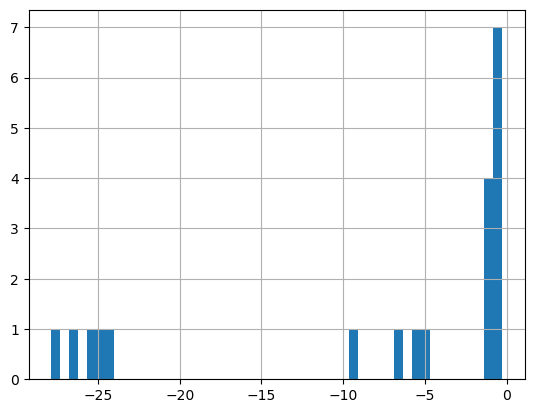

In [80]:
pd.DataFrame(gs_RF.cv_results_)['mean_test_score'].hist(bins=50);

## Regresor KNeighbours

In [35]:
from sklearn.neighbors import KNeighborsRegressor

In [51]:
grilla_KN = {
    "regressor": [KNeighborsRegressor()],
    "regressor__n_neighbors" :[3, 5, 10],
    "regressor__weights" : ['uniform', 'distance'],
    "regressor__metric" :['euclidean'],
    "selector__percentile" : [75, 85, 95, 100],
    "selector__score_func" : [f_classif],
    "procesamiento__BoC-cat__min_df" : [0.05, 0.1],
    "procesamiento__BoC-genres__min_df" : [0.05, 0.1],
    "procesamiento__BoC-tags__min_df" : [0.05, 0.1],
    "procesamiento__BoC-dev__min_df" : [2, 5],
    "procesamiento__BoC-pub__min_df" : [2, 5],
}

gs_KN = HalvingGridSearchCV(
    pipeline,
    grilla_KN,
    scoring = 'r2',
    n_jobs=-1,
    verbose = 0,
    random_state = 1
)

In [52]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore');

gs_KN.fit(X_train, y_train)

/home/camilo/miniconda3/envs/prog_cientifica/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:107: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)
/home/camilo/miniconda3/envs/prog_cientifica/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/camilo/miniconda3/envs/prog_cientifica/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:107: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)
/home/camilo/miniconda3/envs/prog_cientifica/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/camilo/miniconda3/envs/prog_cientifica/lib/python3.10/site-packages/sklearn/feature_selection/_univari

HalvingGridSearchCV(estimator=Pipeline(steps=[('procesamiento',
                                               ColumnTransformer(transformers=[('BoC-plat',
                                                                                CountVectorizer(min_df=0.05,
                                                                                                tokenizer=<preprocessing.CategoriesTokenizer object at 0x7fd781d29bd0>),
                                                                                'platforms'),
                                                                               ('BoC-cat',
                                                                                CountVectorizer(min_df=0.05,
                                                                                                tokenizer=<preprocessing.CategoriesTokenizer object at 0x7fd781d29bd0>),
                                                                                'categories'),
                                                                               ('BoC-genre...
                                'procesamiento__BoC-tags__min_df': [0.05, 0.1],
                                'regressor': [KNeighborsRegressor(metric='euclidean',
                                                                  n_neighbors=10,
                                                                  weights='distance')],
                                'regressor__metric': ['euclidean'],
                                'regressor__n_neighbors': [3, 5, 10],
                                'regressor__weights': ['uniform', 'distance'],
                                'selector__percentile': [75, 85, 95, 100],
                                'selector__score_func': [<function f_classif at 0x7fd7908ff2e0>]},
                    random_state=1, scoring='r2')

El mejor modelo encontrado es:

In [53]:
gs_KN.best_params_ 

{'procesamiento__BoC-cat__min_df': 0.1,
 'procesamiento__BoC-dev__min_df': 5,
 'procesamiento__BoC-genres__min_df': 0.1,
 'procesamiento__BoC-pub__min_df': 5,
 'procesamiento__BoC-tags__min_df': 0.1,
 'regressor': KNeighborsRegressor(metric='euclidean', n_neighbors=10, weights='distance'),
 'regressor__metric': 'euclidean',
 'regressor__n_neighbors': 10,
 'regressor__weights': 'distance',
 'selector__percentile': 95,
 'selector__score_func': <function sklearn.feature_selection._univariate_selection.f_classif(X, y)>}

Y sus resultados son

In [54]:
gs_KN.best_score_

0.15820828019114522

In [55]:
print("Resultados clasificador ganador de GridSearch k-Neighbors Regressor")

y_pred = gs_KN.predict(X_eval)
print("Error cuadrático medio = {}".format(mean_squared_error(y_eval,y_pred)))
print("Score R2 = {}".format(r2_score(y_eval,y_pred)))

Resultados clasificador ganador de GridSearch k-Neighbors Regressor
Error cuadrático medio = 1448658906716.0178
Score R2 = 0.19193713013941716


Resultados generales del gridsearch:

In [56]:
pd.DataFrame(gs_KN.cv_results_)

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_procesamiento__BoC-cat__min_df,param_procesamiento__BoC-dev__min_df,param_procesamiento__BoC-genres__min_df,param_procesamiento__BoC-pub__min_df,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0,10,0.006211,0.004538,0.001286,0.002571,0.05,2,0.05,2,...,NaN,NaN,577,NaN,NaN,NaN,NaN,0.540838,NaN,NaN
1,0,10,0.007665,0.007786,0.001943,0.003886,0.05,2,0.05,2,...,NaN,NaN,772,NaN,NaN,NaN,NaN,0.576656,NaN,NaN
2,0,10,0.007681,0.007716,0.001408,0.002817,0.05,2,0.05,2,...,NaN,NaN,771,NaN,NaN,NaN,NaN,0.598348,NaN,NaN
3,0,10,0.007797,0.005013,0.001301,0.002603,0.05,2,0.05,2,...,NaN,NaN,770,NaN,NaN,NaN,NaN,0.602971,NaN,NaN
4,0,10,0.007700,0.004914,0.001756,0.003512,0.05,2,0.05,2,...,NaN,NaN,769,NaN,NaN,NaN,NaN,1.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1148,4,810,0.039674,0.029432,0.001972,0.003944,0.1,5,0.1,5,...,NaN,NaN,11,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
1149,5,2430,1.247924,0.060002,0.119586,0.021846,0.05,5,0.05,2,...,0.058028,0.164244,6,0.584588,0.557271,0.569233,0.590392,0.567061,0.573709,1.209231e-02
1150,5,2430,1.325569,0.043723,0.122108,0.022886,0.1,5,0.1,5,...,0.158208,0.055252,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.042277e-09
1151,5,2430,1.167850,0.243721,0.088006,0.020127,0.05,5,0.1,2,...,0.140666,0.120933,3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.042277e-09


In [57]:
pd.DataFrame(gs_KN.cv_results_)['mean_test_score'].max()

0.15820828019114522

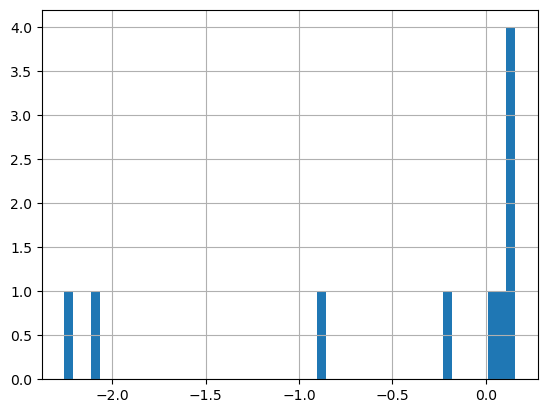

In [83]:
pd.DataFrame(gs_KN.cv_results_)['mean_test_score'].hist(bins=50);

## Regresor Support Vector

In [58]:
from sklearn.svm import SVR

In [59]:
grilla_SV = {
    "regressor": [SVR()],
    "regressor__kernel" : ['linear', 'poly', 'rbf', 'sigmoid'],
    "regressor__C":[1.,100.,1000.],
    "regressor__epsilon" : [0.05, 0.1, 0.2],
    "selector__percentile" : [75, 85, 95, 100],
    "selector__score_func" : [f_classif],
    "procesamiento__BoC-cat__min_df" : [0.05, 0.1],
    "procesamiento__BoC-genres__min_df" : [0.05, 0.1],
    "procesamiento__BoC-tags__min_df" : [0.05, 0.1],
    "procesamiento__BoC-dev__min_df" : [2, 5],
    "procesamiento__BoC-pub__min_df" : [2, 5],
}

gs_SV = HalvingGridSearchCV(
    pipeline,
    grilla_SV,
    scoring = 'r2',
    n_jobs=-1,
    verbose = 0,
    random_state = 1
)

In [60]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore');

gs_SV.fit(X_train, y_train)

/home/camilo/miniconda3/envs/prog_cientifica/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:107: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)
/home/camilo/miniconda3/envs/prog_cientifica/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/camilo/miniconda3/envs/prog_cientifica/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:107: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)
/home/camilo/miniconda3/envs/prog_cientifica/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/camilo/miniconda3/envs/prog_cientifica/lib/python3.10/site-packages/sklearn/feature_selection/_univari

HalvingGridSearchCV(estimator=Pipeline(steps=[('procesamiento',
                                               ColumnTransformer(transformers=[('BoC-plat',
                                                                                CountVectorizer(min_df=0.05,
                                                                                                tokenizer=<preprocessing.CategoriesTokenizer object at 0x7fd781d29bd0>),
                                                                                'platforms'),
                                                                               ('BoC-cat',
                                                                                CountVectorizer(min_df=0.05,
                                                                                                tokenizer=<preprocessing.CategoriesTokenizer object at 0x7fd781d29bd0>),
                                                                                'categories'),
                                                                               ('BoC-genre...
                                'procesamiento__BoC-pub__min_df': [2, 5],
                                'procesamiento__BoC-tags__min_df': [0.05, 0.1],
                                'regressor': [SVR(C=1000.0, kernel='poly')],
                                'regressor__C': [1.0, 100.0, 1000.0],
                                'regressor__epsilon': [0.05, 0.1, 0.2],
                                'regressor__kernel': ['linear', 'poly', 'rbf',
                                                      'sigmoid'],
                                'selector__percentile': [75, 85, 95, 100],
                                'selector__score_func': [<function f_classif at 0x7fd7908ff2e0>]},
                    random_state=1, scoring='r2')

El mejor modelo encontrado es

In [61]:
gs_SV.best_params_

{'procesamiento__BoC-cat__min_df': 0.05,
 'procesamiento__BoC-dev__min_df': 5,
 'procesamiento__BoC-genres__min_df': 0.1,
 'procesamiento__BoC-pub__min_df': 2,
 'procesamiento__BoC-tags__min_df': 0.05,
 'regressor': SVR(C=1000.0, kernel='poly'),
 'regressor__C': 1000.0,
 'regressor__epsilon': 0.1,
 'regressor__kernel': 'poly',
 'selector__percentile': 100,
 'selector__score_func': <function sklearn.feature_selection._univariate_selection.f_classif(X, y)>}

Y sus resultados son:

In [62]:
gs_SV.best_score_

-0.0142066048702568

In [63]:
print("Resultados clasificador ganador de GridSearch SupportVector Regressor")

y_pred = gs_SV.predict(X_eval)
print("Error cuadrático medio = {}".format(mean_squared_error(y_eval,y_pred)))
print("Score R2 = {}".format(r2_score(y_eval,y_pred)))

Resultados clasificador ganador de GridSearch SupportVector Regressor
Error cuadrático medio = 1794075177053.1143
Score R2 = -0.000736287606564856


Resultados generales del gridsearch

In [64]:
pd.DataFrame(gs_SV.cv_results_)

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_procesamiento__BoC-cat__min_df,param_procesamiento__BoC-dev__min_df,param_procesamiento__BoC-genres__min_df,param_procesamiento__BoC-pub__min_df,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0,10,0.013692,0.010565,0.003174,0.006348,0.05,2,0.05,2,...,NaN,NaN,3452,NaN,NaN,NaN,NaN,-0.186012,NaN,NaN
1,0,10,0.010747,0.005595,0.001730,0.003460,0.05,2,0.05,2,...,NaN,NaN,4608,NaN,NaN,NaN,NaN,-0.185913,NaN,NaN
2,0,10,0.012135,0.011751,0.003778,0.007556,0.05,2,0.05,2,...,NaN,NaN,4607,NaN,NaN,NaN,NaN,-0.185017,NaN,NaN
3,0,10,0.013950,0.008404,0.002416,0.004832,0.05,2,0.05,2,...,NaN,NaN,4606,NaN,NaN,NaN,NaN,-0.184998,NaN,NaN
4,0,10,0.007470,0.005809,0.002080,0.004160,0.05,2,0.05,2,...,NaN,NaN,4605,NaN,NaN,NaN,NaN,-0.186592,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6898,5,2430,2.161950,0.088007,0.179745,0.009514,0.05,5,0.1,5,...,-0.038141,0.014221,21,-0.009022,-0.011751,-0.010973,-0.027301,-0.025637,-0.016937,0.007851
6899,5,2430,2.304432,0.083837,0.189277,0.002900,0.05,5,0.1,5,...,-0.039184,0.014704,22,-0.009209,-0.011977,-0.011194,-0.027988,-0.026250,-0.017324,0.008067
6900,5,2430,2.327346,0.090252,0.188529,0.024725,0.1,5,0.1,5,...,-0.017447,0.004204,5,-0.005246,-0.007631,-0.006666,-0.014291,-0.013916,-0.009550,0.003796
6901,5,2430,2.018312,0.085342,0.139912,0.021905,0.05,5,0.1,5,...,-0.017868,0.003991,8,-0.005252,-0.007836,-0.006659,-0.013992,-0.013730,-0.009494,0.003660


In [65]:
pd.DataFrame(gs_SV.cv_results_)['mean_test_score'].max()

0.025013728237069245

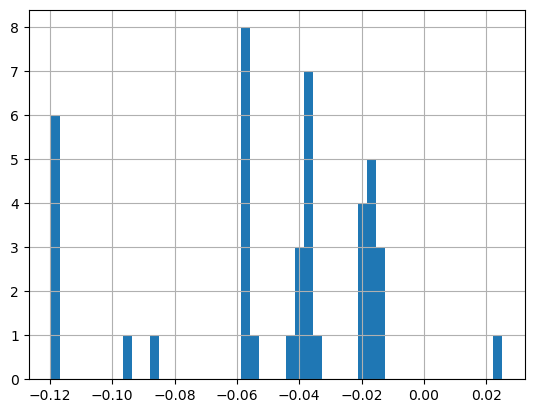

In [84]:
pd.DataFrame(gs_SV.cv_results_)['mean_test_score'].hist(bins=50);

## Regresores lineales

In [66]:
from sklearn.linear_model import ElasticNet, Ridge

In [67]:
grilla_lineal = {
    "regressor": [ElasticNet(random_state=0),Ridge(random_state=0)],
    "regressor__alpha": [0.75, 1, 1.25, 1.5],
    "regressor__tol": [5e-3, 1e-4, 5e-5],
    "selector__percentile" : [75, 85, 95, 100],
    "selector__score_func" : [f_classif],
    "procesamiento__BoC-cat__min_df" : [0.05, 0.1],
    "procesamiento__BoC-genres__min_df" : [0.05, 0.1],
    "procesamiento__BoC-tags__min_df" : [0.05, 0.1],
    "procesamiento__BoC-dev__min_df" : [2, 5],
    "procesamiento__BoC-pub__min_df" : [2, 5],
}

gs_lineal = HalvingGridSearchCV(
    pipeline,
    grilla_lineal,
    scoring = 'r2',
    n_jobs=-1,
    verbose = 0,
    random_state = 1
)

In [68]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore');

gs_lineal.fit(X_train, y_train)

/home/camilo/miniconda3/envs/prog_cientifica/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:107: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)
/home/camilo/miniconda3/envs/prog_cientifica/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/camilo/miniconda3/envs/prog_cientifica/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:107: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)
/home/camilo/miniconda3/envs/prog_cientifica/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/camilo/miniconda3/envs/prog_cientifica/lib/python3.10/site-packages/sklearn/feature_selection/_univari

HalvingGridSearchCV(estimator=Pipeline(steps=[('procesamiento',
                                               ColumnTransformer(transformers=[('BoC-plat',
                                                                                CountVectorizer(min_df=0.05,
                                                                                                tokenizer=<preprocessing.CategoriesTokenizer object at 0x7fd781d29bd0>),
                                                                                'platforms'),
                                                                               ('BoC-cat',
                                                                                CountVectorizer(min_df=0.05,
                                                                                                tokenizer=<preprocessing.CategoriesTokenizer object at 0x7fd781d29bd0>),
                                                                                'categories'),
                                                                               ('BoC-genre...
                                'procesamiento__BoC-pub__min_df': [2, 5],
                                'procesamiento__BoC-tags__min_df': [0.05, 0.1],
                                'regressor': [ElasticNet(alpha=0.75,
                                                         random_state=0,
                                                         tol=0.005),
                                              Ridge(random_state=0)],
                                'regressor__alpha': [0.75, 1, 1.25, 1.5],
                                'regressor__tol': [0.005, 0.0001, 5e-05],
                                'selector__percentile': [75, 85, 95, 100],
                                'selector__score_func': [<function f_classif at 0x7fd7908ff2e0>]},
                    random_state=1, scoring='r2')

Mejor modelo encontrado

In [69]:
gs_lineal.best_params_

{'procesamiento__BoC-cat__min_df': 0.05,
 'procesamiento__BoC-dev__min_df': 5,
 'procesamiento__BoC-genres__min_df': 0.05,
 'procesamiento__BoC-pub__min_df': 2,
 'procesamiento__BoC-tags__min_df': 0.05,
 'regressor': ElasticNet(alpha=0.75, random_state=0, tol=0.005),
 'regressor__alpha': 0.75,
 'regressor__tol': 0.005,
 'selector__percentile': 75,
 'selector__score_func': <function sklearn.feature_selection._univariate_selection.f_classif(X, y)>}

y sus resultados son

In [70]:
gs_lineal.best_score_

0.10428037405038841

In [72]:
print("Resultados clasificador ganador de GridSearch SupportVector Regressor")

y_pred = gs_lineal.predict(X_eval)
print("Error cuadrático medio = {}".format(mean_squared_error(y_eval,y_pred)))
print("Score R2 = {}".format(r2_score(y_eval,y_pred)))

Resultados clasificador ganador de GridSearch SupportVector Regressor
Error cuadrático medio = 1660867628664.6816
Score R2 = 0.0735669685559639


Resultados generales del gridsearch

In [73]:
pd.DataFrame(gs_lineal.cv_results_)

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_procesamiento__BoC-cat__min_df,param_procesamiento__BoC-dev__min_df,param_procesamiento__BoC-genres__min_df,param_procesamiento__BoC-pub__min_df,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0,10,0.017813,0.017292,0.003023,0.006047,0.05,2,0.05,2,...,NaN,NaN,2302,NaN,NaN,NaN,NaN,0.884854,NaN,NaN
1,0,10,0.013423,0.008641,0.002140,0.004279,0.05,2,0.05,2,...,NaN,NaN,3072,NaN,NaN,NaN,NaN,0.908965,NaN,NaN
2,0,10,0.013754,0.013144,0.003175,0.006349,0.05,2,0.05,2,...,NaN,NaN,3071,NaN,NaN,NaN,NaN,0.934638,NaN,NaN
3,0,10,0.011600,0.007123,0.001639,0.003278,0.05,2,0.05,2,...,NaN,NaN,3070,NaN,NaN,NaN,NaN,0.934860,NaN,NaN
4,0,10,0.009067,0.007750,0.001903,0.003806,0.05,2,0.05,2,...,NaN,NaN,3069,NaN,NaN,NaN,NaN,0.884852,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4598,5,2430,1.560650,0.049720,0.033425,0.001160,0.05,5,0.1,2,...,-0.319899,0.500734,11,0.408512,0.278157,0.266539,0.302755,0.311659,0.313524,0.050201
4599,5,2430,1.544131,0.079499,0.032580,0.001299,0.05,5,0.1,2,...,-0.327014,0.509355,13,0.409050,0.279141,0.267767,0.303632,0.312831,0.314484,0.049990
4600,5,2430,1.467419,0.027760,0.049468,0.019584,0.05,5,0.05,2,...,0.104280,0.037213,1,0.061819,0.064745,0.061441,0.100754,0.098817,0.077515,0.018230
4601,5,2430,1.558804,0.039285,0.025444,0.006032,0.05,5,0.1,2,...,-0.368370,0.537460,17,0.422578,0.281507,0.269486,0.310520,0.320685,0.320955,0.054114


In [74]:
pd.DataFrame(gs_lineal.cv_results_)['mean_test_score'].max()

0.10428037405038841

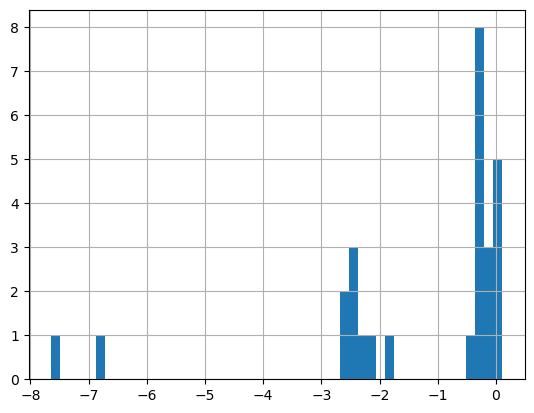

In [85]:
pd.DataFrame(gs_lineal.cv_results_)['mean_test_score'].hist(bins=50);